# Training data for mitosis detection 
Notebook to create template list and make mitosis detection data usable for deep learning. 

## Data
A image series consisting of 399 phase contrast images with 552 mitotic events is used. The training data is available as template images where each mitotic cell is stored in an image with size 41x41. Each file_name is "frame_x-coord_y-coord.png". 

For each mitosis, exactly one image is stored. In this script we use a template matching to extend the number of available training samples / data points: each mitotic event is identified in the frames before and after the recorded image. 

Using this method the number of samples is increased to 2902 samples. 


##  Training data for keras-rcnn 
To make the data **keras-rcnn ready** we create a list containg the bounding box for each mitosis. See
 https://github.com/broadinstitute/keras-rcnn

## The mitosis data was published in 2013, see link below. 

```
@inproceedings{becker2013combining,
  title={Combining phase contrast and immunofluorescence images using geometric hashing},
  author={Becker, Tim and Schultz, Sandra and Rapoport, Daniel H and Mamlouk, Amir Madany},
  booktitle={Biomedical Imaging (ISBI), 2013 IEEE 10th International Symposium on},
  pages={906--909},
  year={2013},
  organization={IEEE}
}
```

6.2017 TB

In [1]:
%matplotlib notebook 

import json
import numpy 
import os
import sys
import time

import skimage.io
import skimage.transform
import skimage.color
import skimage.feature 

import scipy.signal
import scipy.ndimage

import matplotlib.pyplot
import matplotlib.patches

In [2]:
# directory storing 399 phase contrast image data belonging to cetres data
image_dir = '../data/cetres.b_adapted//'

# directory containing mitosis templates 
template_dir = '../data/cetres.b-mi/mitotic_cells/'
template_file_list = os.listdir(template_dir)

# number of previous and next frames to search
search_radius = 20
frameRadius = 6
# max number of frames 
frameMax = 399
threshold = 0.5

In [3]:
# load image given the image number
def getImage(frameNr, image_dir):
    imageName = 'refdataB_C2_' + "%03i.png" % (frameNr,)
    image =  skimage.io.imread(image_dir + imageName)
    return skimage.color.rgb2gray(image)

# helper function to create the image given the frame number
def getImageName(frameNr, image_dir):
    return('refdataB_C2_' + "%03i.png" % (frameNr,))

# peform template matching and extract all areas that "match"
# the template, i.e. that have a correlation above a given 
# threshold. 
def  matchTemplateTemp(image, template, threshold):
    result = skimage.feature.match_template(image, template)
    
    # create a binary mask
    diff = result > threshold
    
    labeled, num_objects = scipy.ndimage.label(diff)
    slices = scipy.ndimage.find_objects(labeled)
    x, y = [], []
    coordinates = []
    for dy,dx in slices:
        x_center = int((dx.start + dx.stop - 1)/2)
        y_center = int((dy.start + dy.stop - 1)/2)
        coordinates.append([x_center, y_center, result[y_center,x_center]])
        
        
    return(coordinates)

def norm2(x1,x2,y1,y2):
    return(  numpy.sqrt((x1-x2)*(x1-x2) + (y1 - y2)*(y1 - y2)))
    
# We use .split() to extract the frame, x and y coordinate from each file_name.  
def coordinatesFromfile_name(file_name):
    frame, x, y = file_name.replace(".png","").split("_")
    frame = int(frame) 
    x = int(x) 
    y = int(y)
    return (x,y,frame)

refdataB_C2_101.png


<IPython.core.display.Javascript object>


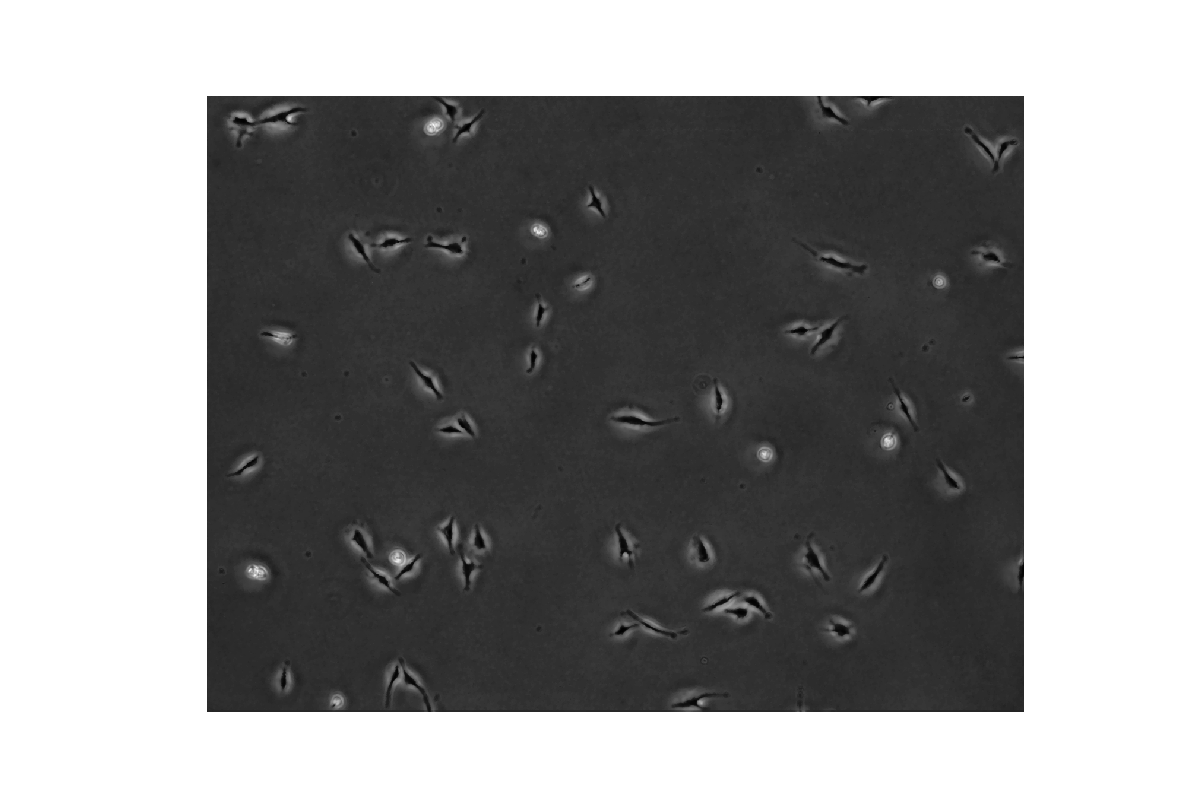

(-0.5, 1375.5, 1037.5, -0.5)

In [4]:
# show sample image
frame = 101
print(getImageName(frame,image_dir))
cellImage = getImage(frame, image_dir)

fig, ax = matplotlib.pyplot.subplots(figsize=(6, 4))
ax.imshow(cellImage, cmap = "gray")
matplotlib.pyplot.axis('off')

## template matching
The template matching skimage.feature.match_template is used to identify the same mitosisin several frames 

In [5]:
templates_per_image = {}
templates_per_frame = {}

for file_name in template_file_list:
    templateImage = skimage.color.rgb2gray(skimage.io.imread(template_dir + file_name))
    (x,y,frame) = coordinatesFromfile_name(file_name)
        
    # loop over previous and next images
    for iFrame in range(frame - frameRadius, frame + frameRadius):
        
        if iFrame > 0 and iFrame <= frameMax:
            cellImage = getImage(iFrame, image_dir)
            coordinates = matchTemplateTemp(cellImage, templateImage,threshold)
            
            # We make sure the matching cell is within the search radius  
            for iCoord in coordinates:
                if norm2(x,iCoord[0],y,iCoord[1]) < search_radius:
                    try: templates_per_image[getImageName(iFrame,image_dir)].append( (iCoord[0],iCoord[1],iCoord[2]) )
                    except: templates_per_image[getImageName(iFrame,image_dir)] = [ (iCoord[0],iCoord[1],iCoord[2]) ]
                    try: templates_per_frame[iFrame].append( (iCoord[0],iCoord[1],iCoord[2]) )
                    except: templates_per_frame[iFrame] = [ (iCoord[0],iCoord[1],iCoord[2]) ]
                    break 
                
                

KeyboardInterrupt: 

## Plot bounding boxes in a time series 
In the following code two ways are shown to plot bounding boxes. 
The first uses matplotlib.patches; this is the most convenient one. The second version plots the bounding boxes using the x y coordinates and a imple plot() command. The second version is used to test if the bounding boxes stored in the json file are correct. 

<IPython.core.display.Javascript object>


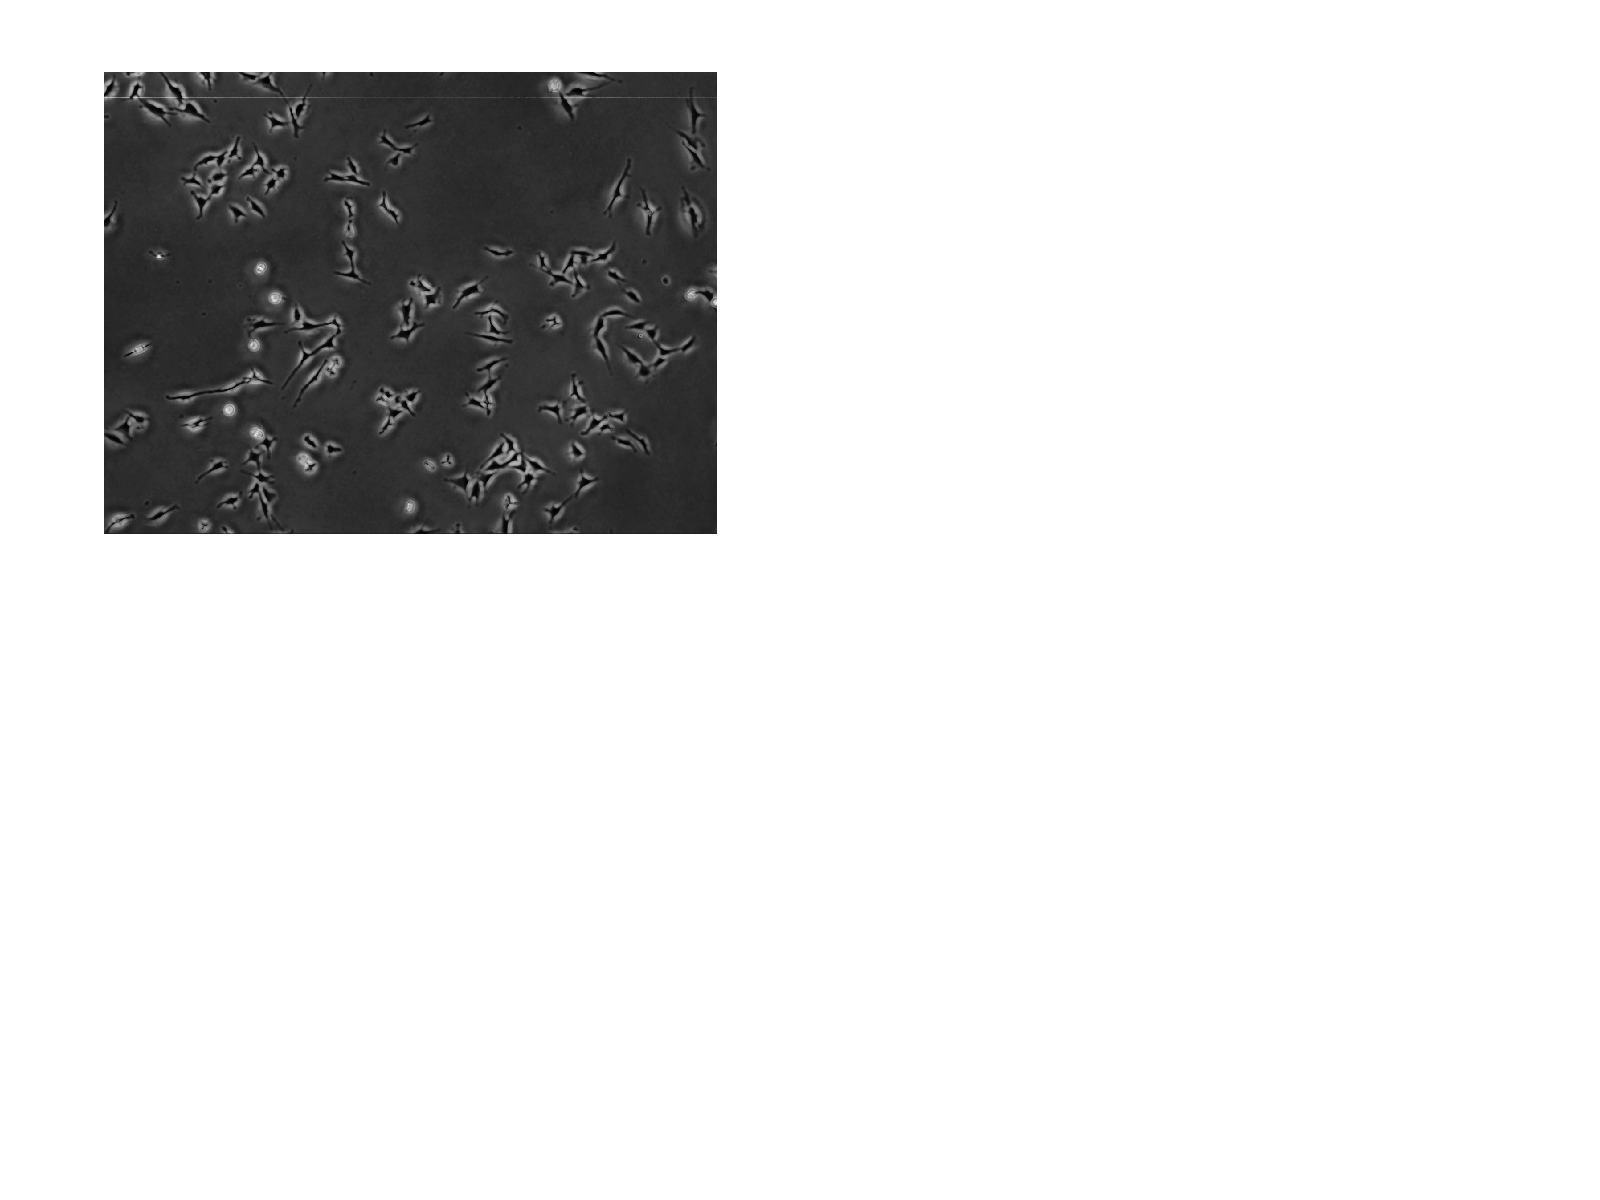

KeyboardInterrupt: 

In [6]:
# using matplotlib we can updated the figure each iteration 
fig, ax = matplotlib.pyplot.subplots(figsize=(8, 6))

for frame in range(200,350,1):   
    # clear axis to remove patches (rect objects)
    matplotlib.pyplot.cla()
    cellImage = getImage(frame, image_dir)
    ax.imshow(cellImage,cmap='gray')
    matplotlib.pyplot.axis('off')
    # ignore frames without mitotic events
    if frame in templates_per_frame:
        for corner in templates_per_frame[frame]:
            #rect = matplotlib.patches.Rectangle(corner, 41, 41, fill=False, edgecolor='red', linewidth=2)
            #ax.add_patch(rect)
            x1 = corner[0]
            x2 = (x1 + 41) 
            y1 = corner[1] 
            y2 = (y1 + 41)
            matplotlib.pyplot.plot([x1, x2], [y1, y1], 'r-')
            matplotlib.pyplot.plot([x1, x2], [y2, y2], 'r-')
            matplotlib.pyplot.plot([x2, x2], [y1, y2], 'r-')
            matplotlib.pyplot.plot([x1, x1], [y1, y2], 'r-')
        
    # make each frame visible
    fig.canvas.draw()    

## Export template list as json file

To use the keras-rcnn implementation we store the training data in a json file. This data file stores the file_name and the bounding boxes of the objects in the images.

We follow the format in the example data from Hung et al. that can be downloaded at http://keras-rcnn.storage.googleapis.com/malaria.tar.gz

In [11]:
# loop over all image
templateList = []

for key in templates_per_image:
    template = {}
    boxList = []
    
    for xy in templates_per_image[key]:
        x = xy[0]
        y = xy[1]
        theta = xy[2]
        bbox = {"class" : "mitosis", 
                "x1" : x, 
                "x2" : (x + 41) , 
                "y1" : y, 
                "y2" : (y + 41)
               } 
        boxList.append(bbox)
    
    template = {"boxes" : boxList, 
         "file_name" : key, 
         "shape" : [1376, 1038, 3] 
        }
    
    templateList.append(template)  
    
with open('../data/bbox_mitosis.json', 'w') as fp:
    json.dump(templateList, fp, indent=4)
    
# list comprehension 
sum([len(template["boxes"]) for template in templateList], 0) 

2057

In [12]:
# read json file 
file_test = '../data/bbox_mitosis.json'

        
fp = open(file_test)

mitosis_data = json.load(fp)


How may mitosis samples do we have?

In [13]:
# list comprehension 
#sum([len(template["boxes"]) for template in test_data], 0) 

NameError: name 'test_data' is not defined